## Rating Prediction on Github Repositories

As platforms like GitHub become more popular, the number of stars on a project shows how much interest it gets from the community. Being able to predict the number of stars can help developers understand what people like, improve their projects, and make them more visible to attract more users and contributors.

### Import Librearies

In [248]:
%pip install ydata_profiling ipywidgets xgboost --quiet

Note: you may need to restart the kernel to use updated packages.


In [249]:
%matplotlib inline

In [250]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

### Import Data

In [251]:
df = pd.read_csv('data/github-repo-data.csv')

In [252]:
# Print shape
df.shape

(150520, 23)

The dataset has 150520 rows and 23 columns.

In [253]:
# Print columns
df.columns

Index(['Name', 'Description', 'URL', 'Created At', 'Updated At', 'Homepage',
       'Size', 'Stars', 'Forks', 'Issues', 'Language', 'License', 'Topics',
       'Has Issues', 'Has Projects', 'Has Downloads', 'Has Wiki', 'Has Pages',
       'Has Discussions', 'Is Fork', 'Is Archived', 'Is Template',
       'Default Branch'],
      dtype='object')

This dataset contains metadata about GitHub repositories, including basic details like the repository’s name, description, URL, creation and update dates, and primary programming language. It also includes metrics like size, stars, forks, issues, and license type. Features such as topics, wiki, GitHub Pages, discussions, and project management tools are captured with boolean indicators. Additionally, it notes whether the repository is a fork, template, or archived, and specifies the default branch. These attributes provide a detailed overview for analyzing repository characteristics and activity.

In [254]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150520 entries, 0 to 150519
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             150520 non-null  object 
 1   Description      144890 non-null  object 
 2   URL              150520 non-null  object 
 3   Created At       150520 non-null  object 
 4   Updated At       150520 non-null  object 
 5   Homepage         54809 non-null   object 
 6   Size             150520 non-null  int64  
 7   Stars            150520 non-null  int64  
 8   Forks            150518 non-null  float64
 9   Issues           150520 non-null  int64  
 10  Language         139289 non-null  object 
 11  License          113325 non-null  object 
 12  Topics           150520 non-null  object 
 13  Has Issues       150520 non-null  bool   
 14  Has Projects     150520 non-null  bool   
 15  Has Downloads    150520 non-null  bool   
 16  Has Wiki         150520 non-null  bool

In [255]:
df.head()

Name  \
0                static-land   
1               markdown-pdf   
2                     pyflow   
3  User-loan-risk-prediction   
4             Sphero-iOS-SDK   

                                         Description  \
0  Specification for common algebraic structures ...   
1         :page_facing_up: Markdown to PDF converter   
2  Fast, accurate and easy to run dense optical f...   
3                               马上AI全球挑战者大赛 rank 1st   
4  🚫 DEPRECATED: Sphero™ is the amazing robotic b...   

                                                 URL            Created At  \
0         https://github.com/fantasyland/static-land  2016-03-12T18:04:07Z   
1           https://github.com/alanshaw/markdown-pdf  2013-05-17T16:29:42Z   
2                 https://github.com/pathak22/pyflow  2016-07-16T04:50:01Z   
3  https://github.com/chenkkkk/User-loan-risk-pre...  2018-06-08T05:29:31Z   
4       https://github.com/sphero-inc/Sphero-iOS-SDK  2011-05-09T05:57:32Z   

             Updated At                                Homepage    Size  \
0  2023-09-08T17:08:03Z                                     NaN     120   
1  2023-09-24T18:31:55Z  https://npmjs.org/package/markdown-pdf     422   
2  2023-09-22T02:38:05Z                                     NaN     899   
3  2023-09-24T08:10:38Z                                     NaN     742   
4  2023-08-24T22:20:20Z                   http://sdk.sphero.com  147126   

   Stars  Forks  Issues  ... Has Issues Has Projects Has Downloads  Has Wiki  \
0    756   45.0      11  ...       True         True          True      True   
1   2573  258.0      90  ...       True         True          True      True   
2    635  137.0      21  ...       True         True          True      True   
3    247  103.0       0  ...       True         True          True      True   
4    225   81.0      19  ...       True         True          True      True   

   Has Pages  Has Discussions  Is Fork  Is Archived  Is Template  \
0      False            False    False        False        False   
1      False            False    False        False        False   
2      False            False    False        False        False   
3      False            False    False        False        False   
4      False            False    False         True        False   

   Default Branch  
0          master  
1          master  
2          master  
3          master  
4          master  

[5 rows x 23 columns]

In [256]:
df.describe()

Size          Stars          Forks         Issues
count  1.505200e+05  150520.000000  150518.000000  150520.000000
mean   5.423895e+04    1117.169313     233.165103      37.626056
std    6.600855e+05    3959.312859    1100.620630     178.576932
min    0.000000e+00     167.000000      -5.000000       0.000000
25%    3.780000e+02     237.000000      39.000000       3.000000
50%    2.396500e+03     378.000000      79.000000      10.000000
75%    1.523425e+04     800.000000     175.000000      28.000000
max    1.048802e+08  298393.000000  142778.000000   20875.000000

### EDA

In [257]:
profile = ProfileReport(df.drop('Description', axis=1), title="Github Metadata Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [258]:
data = df.copy()

#### Skewed Distribution

- **Highly Skewed Variables**:
  - `Size`: Most repositories are small, with a few very large ones.
  - `Stars`: Most repositories have very few stars, with some being extremely popular.
  - `Forks`: Many repositories have few forks, but a small subset has a very high number.
  - `Issues`: Most repositories have few issues, with a minority having disproportionately many.

**Recommendation**:
- Apply log transformations to reduce skewness for `Size`, `Stars`, `Forks`, and `Issues`.
- Investigate outliers separately to understand their impact on the dataset.

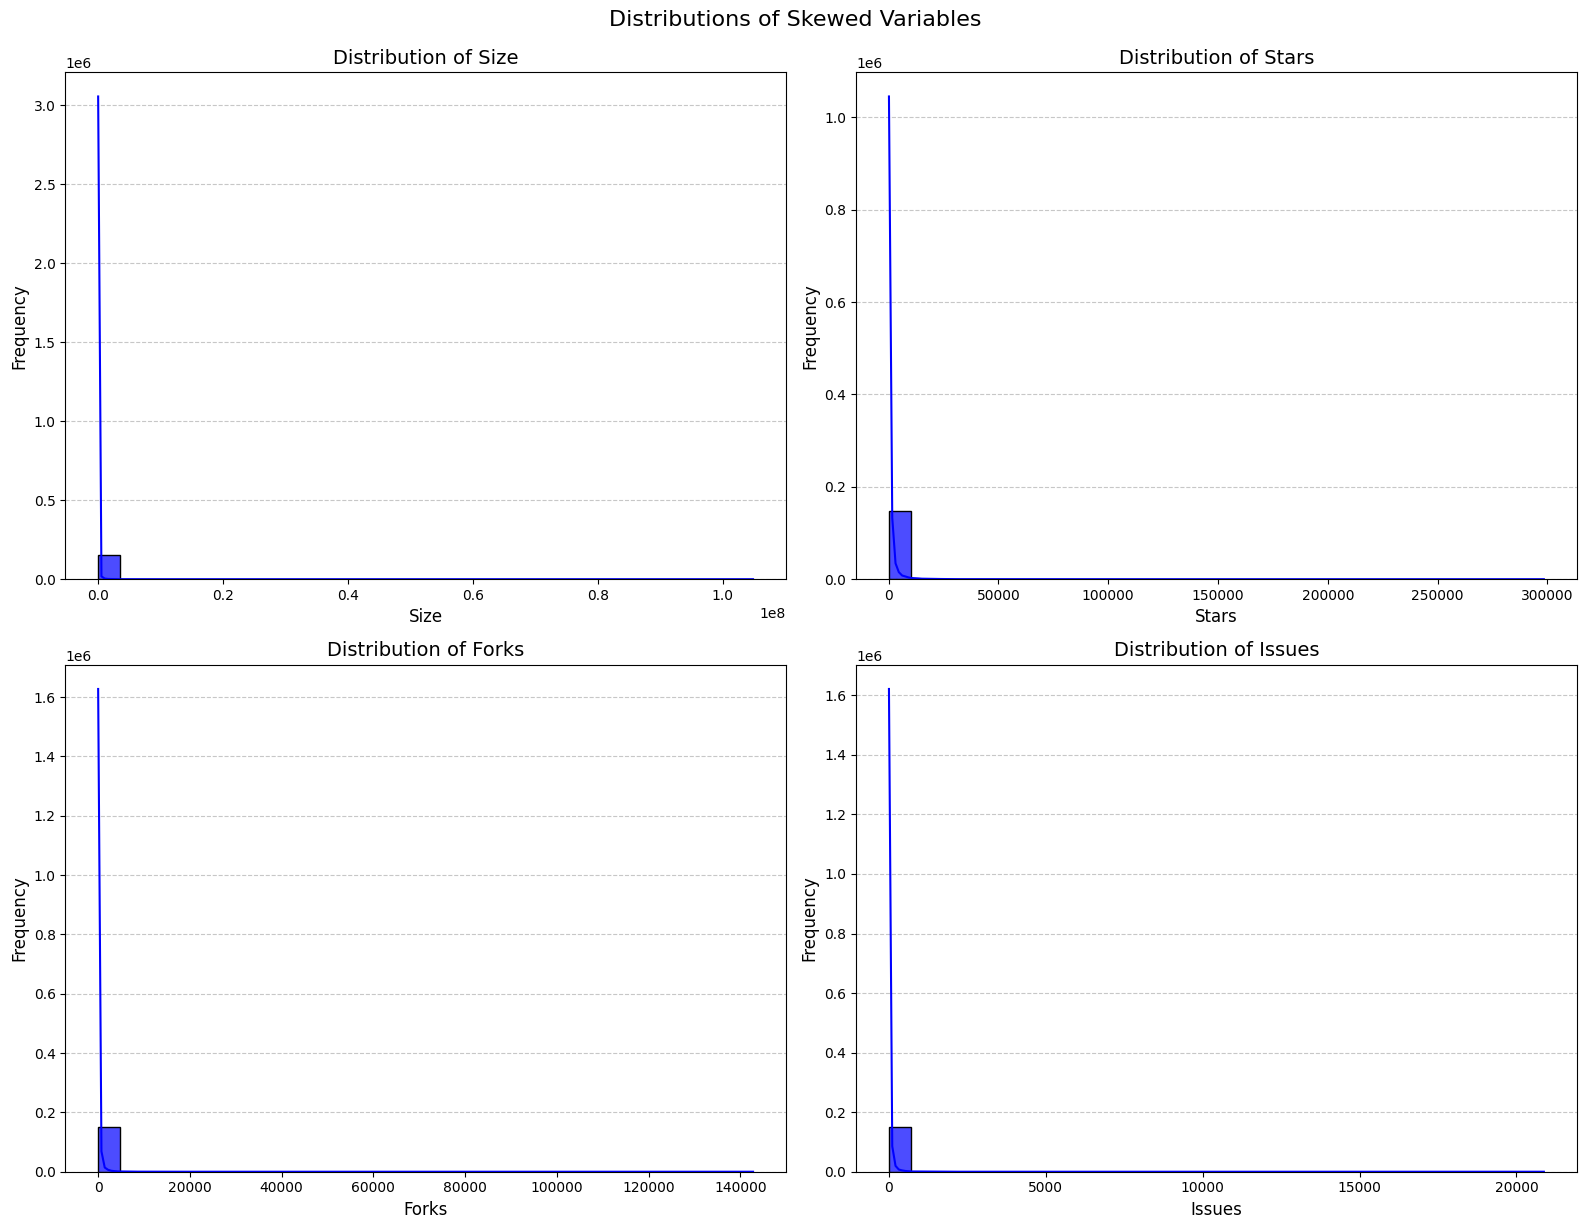

In [259]:
# Select variables to visualize
skewed_columns = ["Size", "Stars", "Forks", "Issues"]

# Set up the figure
plt.figure(figsize=(16, 12))

# Loop through each variable to create a subplot
for i, column in enumerate(skewed_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=data, 
        x=column, 
        kde=True,  # Add kernel density estimate
        bins=30,   # Number of bins
        color="blue",
        alpha=0.7
    )
    plt.title(f"Distribution of {column}", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.suptitle("Distributions of Skewed Variables", fontsize=16, y=1.02)
plt.show()

In [260]:
# Check Negative Values
df[(df['Forks'] < 0) | (df['Stars'] < 0) | (df['Size'] < 0) | (df['Issues'] < 0)].head()

Name                                        Description  \
35005   custom-scripts  A repository of custom scripts to be used with...   
122727      gocov-html  Make pretty HTML output from gocov, a coverage...   
143648   ggVennDiagram             A 'ggplot2' implement of Venn Diagram.   

                                                   URL            Created At  \
35005   https://github.com/sentinel-hub/custom-scripts  2017-10-10T12:18:17Z   
122727              https://github.com/matm/gocov-html  2013-01-17T20:42:50Z   
143648     https://github.com/gaospecial/ggVennDiagram  2019-07-08T14:20:28Z   

                  Updated At                                     Homepage  \
35005   2023-08-22T09:54:14Z                                          NaN   
122727  2023-09-11T06:57:28Z                                          NaN   
143648  2023-09-22T17:55:34Z  https://gaospecial.github.io/ggVennDiagram/   

           Size  Stars  Forks  Issues  ... Has Issues Has Projects  \
35005   1119773    617   -5.0       1  ...       True         True   
122727     1577    200   -3.0       1  ...       True         True   
143648    22108    216   -3.0       3  ...       True         True   

       Has Downloads  Has Wiki  Has Pages  Has Discussions  Is Fork  \
35005           True      True       True            False    False   
122727          True     False      False            False    False   
143648          True      True       True            False    False   

        Is Archived  Is Template  Default Branch  
35005         False        False          master  
122727        False        False          master  
143648        False        False          master  

[3 rows x 23 columns]

`Forks` has negative values that doesn't represent the reality, in order to transform it we have to inpute negative values with 0.

In [261]:
def log_transform(df, columns):
    ''' Apply log transformation to skewed columns'''
    for column in columns:
        df[column] = np.where(df[column] < 0, 0, df[column])
        df[column] = np.log1p(df[column])
    return df

In [262]:
# Inpute and Transform Skewed Columns
data = log_transform(data, skewed_columns)

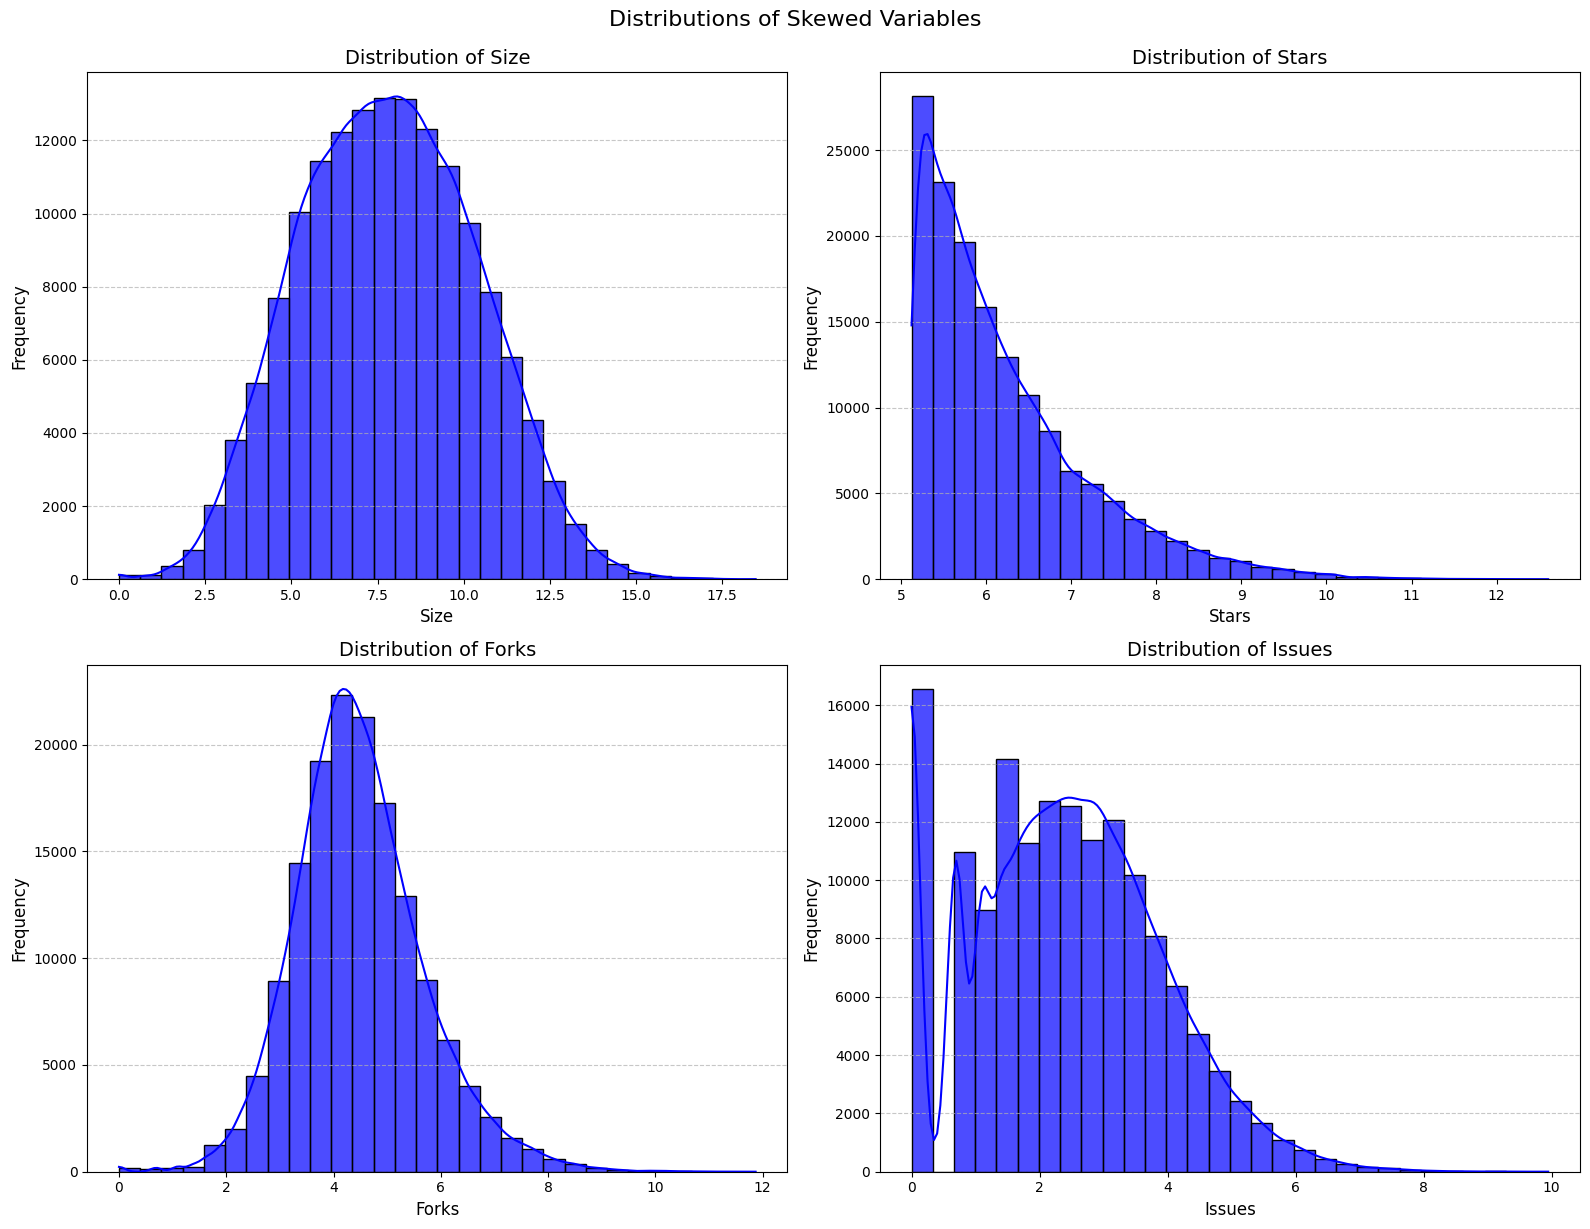

In [263]:
# Select variables to visualize
skewed_columns = ["Size", "Stars", "Forks", "Issues"]

# Set up the figure
plt.figure(figsize=(16, 12))

# Loop through each variable to create a subplot
for i, column in enumerate(skewed_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=data, 
        x=column, 
        kde=True,  # Add kernel density estimate
        bins=30,   # Number of bins
        color="blue",
        alpha=0.7
    )
    plt.title(f"Distribution of {column}", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.suptitle("Distributions of Skewed Variables", fontsize=16, y=1.02)
plt.show()

In [264]:
# Calculate skewness for the skewed columns
for col in skewed_columns:
    col_skewness = skew(data[col])
    print(f"Skewness of {col}: {col_skewness:.4f}")

Skewness of Size: 0.0893
Skewness of Stars: 1.4156
Skewness of Forks: nan
Skewness of Issues: 0.2981


The transformations have effectively reduced the skewness for most variables, improving their distributions. However, for `Forks`, further preprocessing is required to handle null values before skewness can be properly assessed.

#### Handle Missing Data 
- Impute missing values for critical variables (`License`, `Language`) with placeholders like "Unknown."
- Inpute missing values for `Forks`
- For `Homepage`, consider dropping it if the missing data does not significantly impact analysis or create a dummy if having a homepage has a significant impact.

`Homepage` referenses the project owner page. It is null if the creator doesn't have one. To extract valuable information from this variable we will create a new boolean column called `Has Homepage` being True if there is a homepage.

In [265]:
data['Has Homepage'] = data['Homepage'].notna().astype(int)
data.groupby('Has Homepage').describe()['Stars']

count      mean       std       min       25%       50%  \
Has Homepage                                                              
0             95711.0  6.101943  0.882115  5.123964  5.433722  5.852202   
1             54809.0  6.429307  1.119347  5.123964  5.552960  6.124683   

                   75%       max  
Has Homepage                      
0             6.516193  12.50617  
1             7.029088  12.60617

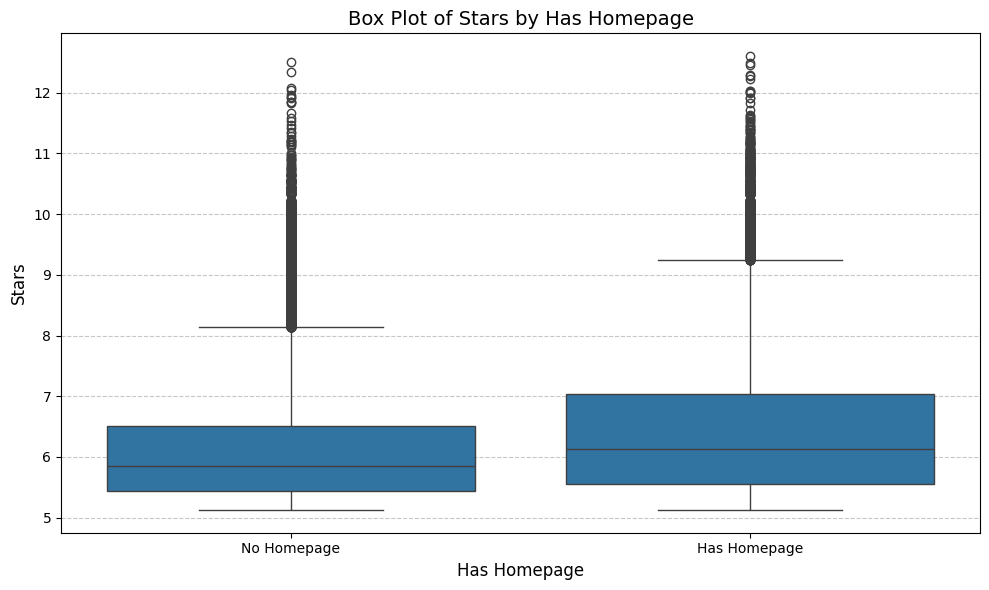

In [266]:
# Visualize Distribution Using Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=data,
    x="Has Homepage",  # Categories on the x-axis
    y="Stars"         # Numerical variable on the y-axis
)

# Add titles and labels
plt.title("Box Plot of Stars by Has Homepage", fontsize=14)
plt.xlabel("Has Homepage", fontsize=12)
plt.ylabel("Stars", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["No Homepage", "Has Homepage"])  # Rename x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

`Language` represents the coding languages used on the project. We will need to check if empty languages mean incomplete projects or if its null because of a scraping error or any other reason. The variable will be processed later to encode it the best way posible. 

In [267]:
# Check Hypothesis: Are the NULL languages empty projects with fewer stars?
data['Has Language'] = data['Language'].notna().astype(int)
data.groupby('Has Language').describe()['Stars']

count      mean       std       min       25%       50%  \
Has Language                                                               
0              11231.0  6.283707  1.036651  5.123964  5.505332  5.991465   
1             139289.0  6.216102  0.983629  5.123964  5.472271  5.932245   

                   75%        max  
Has Language                       
0             6.773080  12.606170  
1             6.678342  12.455336

In [268]:
# Replace empty language with "Unknown"
data['Language'] = data['Language'].fillna("Unknown")
data['Language'].value_counts()

Language
Python        23973
JavaScript    22251
Unknown       11231
Java          10759
TypeScript     8118
              ...  
Ballerina         1
Uno               1
D2                1
RPM Spec          1
ZIL               1
Name: count, Length: 342, dtype: int64

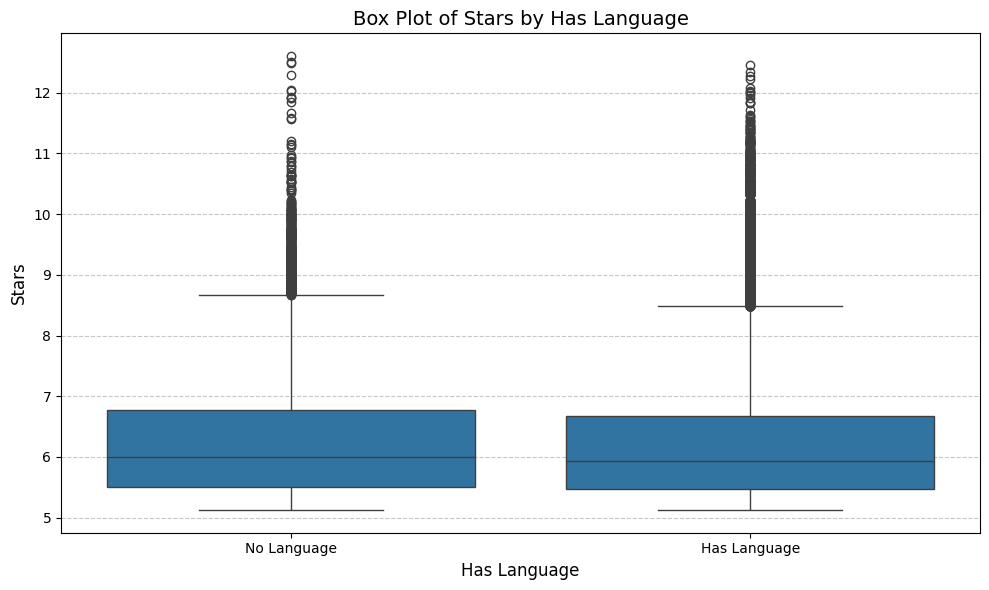

In [269]:
# Visualize Distribution Using Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=data,
    x="Has Language",  # Categories on the x-axis
    y="Stars"        # Numerical variable on the y-axis
)

# Add titles and labels
plt.title("Box Plot of Stars by Has Language", fontsize=14)
plt.xlabel("Has Language", fontsize=12)
plt.ylabel("Stars", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["No Language", "Has Language"])  # Rename x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

There is no evident fundament to infer that having null language means that the project is empty or incomplete. A project with no language could still have many starts.

** Note:

A Statistical Hypothesis Test to prove that the mean number of Stars is the same for repositories with and without a language would be useful in this scenario. (Mann-Whitney / T-test)

`License` 

In [270]:
data['Has License'] = data['License'].notna().astype(int)
data.groupby('Has License').describe()['Stars']

count      mean       std       min       25%       50%  \
Has License                                                               
0             37195.0  6.021287  0.837820  5.123964  5.398163  5.771441   
1            113325.0  6.286743  1.023872  5.123964  5.505332  6.001415   

                  75%        max  
Has License                       
0            6.388561  12.290542  
1            6.782192  12.606170

In [271]:
# Replace empty license with "Unknown"
data['License'] = data['License'].fillna("Unknown")
data['License'].value_counts()

License
MIT                   54801
Unknown               37195
Apache-2.0            19220
NOASSERTION           14792
GPL-3.0                8979
BSD-3-Clause           3640
GPL-2.0                2432
AGPL-3.0               1647
BSD-2-Clause           1364
CC0-1.0                1039
MPL-2.0                 890
LGPL-3.0                821
Unlicense               801
ISC                     626
LGPL-2.1                428
CC-BY-4.0               330
CC-BY-SA-4.0            253
EPL-1.0                 248
WTFPL                   213
Zlib                    140
BSL-1.0                 117
OFL-1.1                 105
EPL-2.0                  82
MIT-0                    80
MS-PL                    51
OSL-3.0                  37
0BSD                     35
Artistic-2.0             26
LPPL-1.3c                21
BSD-4-Clause             16
EUPL-1.2                 15
PostgreSQL               15
BSD-3-Clause-Clear       14
UPL-1.0                  13
AFL-3.0                   7
NCSA        

There is no evident fundament to infer that having or not null license means that the project wont be popular. 

** Note:

A Statistical Hypothesis Test to prove that the mean number of Stars is the same for repositories with and without a language would be useful in this scenario. (Mann-Whitney / T-test)



Hidden Nulls?

In [272]:
# Check for nulls and unusual placeholder values
def check_hidden_nulls(df):
    print("Summary of Hidden Nulls:")
    
    # Check standard nulls (NaN or None)
    print(f"\nStandard Nulls (NaN/None):\n{df.isnull().sum()}")
    
    # Check for empty strings
    empty_strings = (df == "").sum()
    print(f"\nEmpty Strings:\n{empty_strings}")
    
    # Convert all object columns to uppercase for consistent comparison
    df_upper = df.apply(lambda x: x.str.upper() if x.dtypes == 'object' else x)
    
    # Check for "NA" values
    na_values = (df_upper.apply(lambda x: x.str.contains(r'^(NA)$', na=False) if x.dtypes == 'object' else False)).sum()
    print(f"\n'NA' Values:\n{na_values}")
    
    # Check for "NULL" values
    null_values = (df_upper.apply(lambda x: x.str.contains(r'^(NULL)$', na=False) if x.dtypes == 'object' else False)).sum()
    print(f"\n'NULL' Values:\n{null_values}")
    
    # Check for "UNKNOWN" values
    unknown_values = (df_upper.apply(lambda x: x.str.contains(r'^(UNKNOWN)$', na=False) if x.dtypes == 'object' else False)).sum()
    print(f"\n'Unknown' Values:\n{unknown_values}")

    # Check for "[]" values
    unknown_values = (df_upper.apply(lambda x: x =="[]")).sum()
    print(f"\n'[] Values:\n{unknown_values}")
    
    # Check for whitespaces
    whitespace_values = (df_upper.apply(lambda x: x.str.isspace() if x.dtypes == 'object' else False)).sum()
    print(f"\nWhitespace-only Values:\n{whitespace_values}")

# Run the function
check_hidden_nulls(data)

Summary of Hidden Nulls:

Standard Nulls (NaN/None):
Name                   0
Description         5630
URL                    0
Created At             0
Updated At             0
Homepage           95711
Size                   0
Stars                  0
Forks                  2
Issues                 0
Language               0
License                0
Topics                 0
Has Issues             0
Has Projects           0
Has Downloads          0
Has Wiki               0
Has Pages              0
Has Discussions        0
Is Fork                0
Is Archived            0
Is Template            0
Default Branch         0
Has Homepage           0
Has Language           0
Has License            0
dtype: int64

Empty Strings:
Name               0
Description        0
URL                0
Created At         0
Updated At         0
Homepage           0
Size               0
Stars              0
Forks              0
Issues             0
Language           0
License            0
Topics          

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/2057501545.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  na_values = (df_upper.apply(lambda x: x.str.contains(r'^(NA)$', na=False) if x.dtypes == 'object' else False)).sum()



'NA' Values:
Name               0
Description        0
URL                0
Created At         0
Updated At         0
Homepage           0
Size               0
Stars              0
Forks              0
Issues             0
Language           0
License            0
Topics             0
Has Issues         0
Has Projects       0
Has Downloads      0
Has Wiki           0
Has Pages          0
Has Discussions    0
Is Fork            0
Is Archived        0
Is Template        0
Default Branch     0
Has Homepage       0
Has Language       0
Has License        0
dtype: int64


/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/2057501545.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  null_values = (df_upper.apply(lambda x: x.str.contains(r'^(NULL)$', na=False) if x.dtypes == 'object' else False)).sum()



'NULL' Values:
Name               0
Description        0
URL                0
Created At         0
Updated At         0
Homepage           0
Size               0
Stars              0
Forks              0
Issues             0
Language           0
License            0
Topics             0
Has Issues         0
Has Projects       0
Has Downloads      0
Has Wiki           0
Has Pages          0
Has Discussions    0
Is Fork            0
Is Archived        0
Is Template        0
Default Branch     0
Has Homepage       0
Has Language       0
Has License        0
dtype: int64


/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/2057501545.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  unknown_values = (df_upper.apply(lambda x: x.str.contains(r'^(UNKNOWN)$', na=False) if x.dtypes == 'object' else False)).sum()



'Unknown' Values:
Name                   0
Description            0
URL                    0
Created At             0
Updated At             0
Homepage               0
Size                   0
Stars                  0
Forks                  0
Issues                 0
Language           11231
License            37195
Topics                 0
Has Issues             0
Has Projects           0
Has Downloads          0
Has Wiki               0
Has Pages              0
Has Discussions        0
Is Fork                0
Is Archived            0
Is Template            0
Default Branch         0
Has Homepage           0
Has Language           0
Has License            0
dtype: int64

'[] Values:
Name                   0
Description            0
URL                    0
Created At             0
Updated At             0
Homepage               0
Size                   0
Stars                  0
Forks                  0
Issues                 0
Language               0
License                0
Topic

`Topics` have Null values implaced with empty brackets

There aren't any other hidden nulls with paraphrases that could represent null values. 

In [273]:
data['Has Topics'] = (data['Topics'].str.strip() == "[]").astype(int)
data.groupby('Has Topics')['Stars'].describe()

count      mean       std       min       25%       50%  \
Has Topics                                                              
0           79908.0  6.354923  1.068952  5.123964  5.533389  6.059123   
1           70612.0  6.069758  0.862481  5.123964  5.420535  5.823046   

                 75%        max  
Has Topics                       
0           6.886532  12.606170  
1           6.467699  12.498377

In [274]:
# Replace empty topics with "Unknown"
data['Topics'] = data['Topics'].replace("[]", "['Unknown']")
data['Topics'].value_counts()

Topics
['Unknown']                                                                                                                                                                                                       70612
['hacktoberfest']                                                                                                                                                                                                   320
['python']                                                                                                                                                                                                           34
['android']                                                                                                                                                                                                          33
['component', 'php', 'symfony', 'symfony-component']                                                                             

#### TimeSeries
Create variables that represent frequency between today and creation and last updated dates

In [275]:
# Convert "Created At" and "Updated At" to timezone-naive datetime
data["Created At"] = pd.to_datetime(data["Created At"]).dt.tz_localize(None)
data["Updated At"] = pd.to_datetime(data["Updated At"]).dt.tz_localize(None)

# Get today's date as timezone-naive
today = pd.Timestamp.today().replace(tzinfo=None)

# Calculate differences in days
data["LastCreated"] = (today - data["Created At"]).dt.days
data["LastUpdated"] = (today - data["Updated At"]).dt.days

# Display the updated DataFrame
print(data[["Created At", "Updated At", "LastCreated", "LastUpdated"]].head())


           Created At          Updated At  LastCreated  LastUpdated
0 2016-03-12 18:04:07 2023-09-08 17:08:03         3232          496
1 2013-05-17 16:29:42 2023-09-24 18:31:55         4262          479
2 2016-07-16 04:50:01 2023-09-22 02:38:05         3106          482
3 2018-06-08 05:29:31 2023-09-24 08:10:38         2414          480
4 2011-05-09 05:57:32 2023-08-24 22:20:20         5001          510


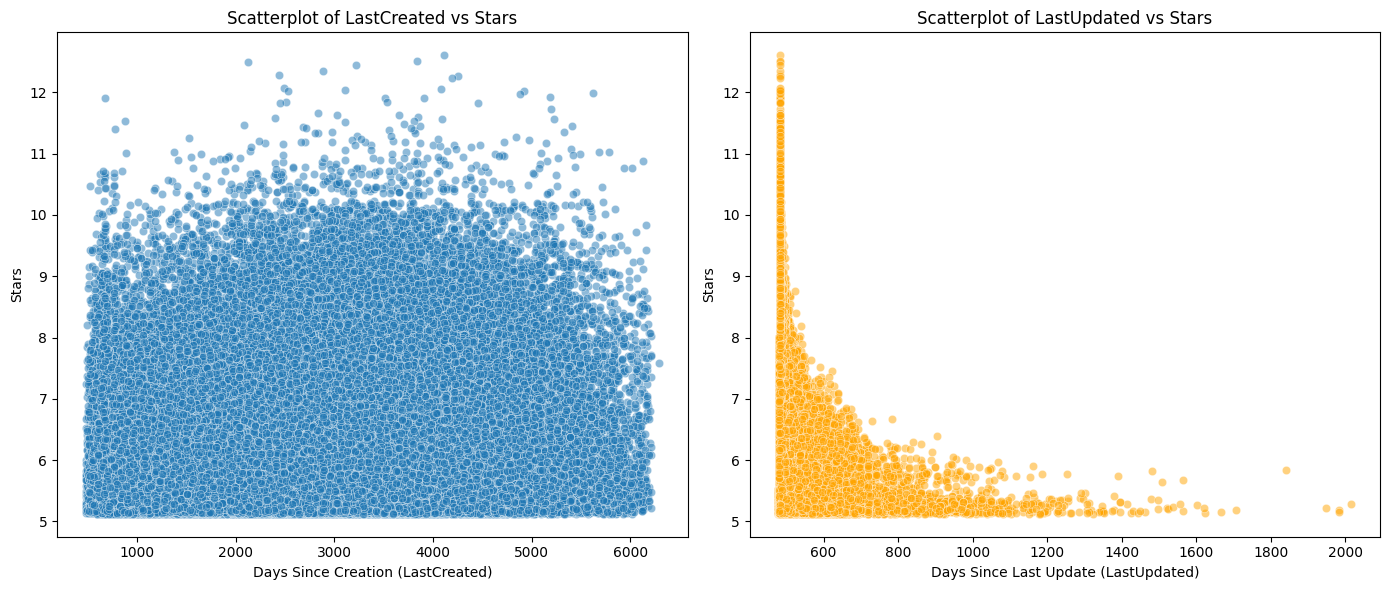

In [276]:
# Create scatterplots
plt.figure(figsize=(14, 6))

# Scatterplot for LastCreated vs Stars
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x="LastCreated", y="Stars", alpha=0.5)
plt.title("Scatterplot of LastCreated vs Stars")
plt.xlabel("Days Since Creation (LastCreated)")
plt.ylabel("Stars")
plt.grid(False)

# Scatterplot for LastUpdated vs Stars
plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x="LastUpdated", y="Stars", alpha=0.5, color="orange")
plt.title("Scatterplot of LastUpdated vs Stars")
plt.xlabel("Days Since Last Update (LastUpdated)")
plt.ylabel("Stars")
plt.grid(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

LastUpdated could be a valuable feature for predicting stars, given the apparent inverse relationship between recency of updates and popularity.

#### Categorical Variables

In [277]:
# Identify categorical variables
categorical_columns = data.select_dtypes(include=["object", "category"]).columns

# Print categorical variables
print("Categorical Variables:")
print(categorical_columns.tolist())

Categorical Variables:
['Name', 'Description', 'URL', 'Homepage', 'Language', 'License', 'Topics', 'Default Branch']


In [278]:
data['Default Branch'].value_counts()

Default Branch
master         114052
main            28755
develop          2378
dev               857
gh-pages          590
                ...  
soar-web-go         1
NewsAPP             1
phantom             1
L02_9.x             1
2.8.x               1
Name: count, Length: 1730, dtype: int64

There are many values for `Default Branch` instead of using the original variable we will replace the not common names with Others. 

In [279]:
# Step 1: Identify the top 3 Default Branches
top_3_branches = data["Default Branch"].value_counts().nlargest(3).index

# Step 2: Create the new variable 'Branch'
data["Branch"] = data["Default Branch"].apply(lambda x: x if x in top_3_branches else "Others")

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/143324782.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


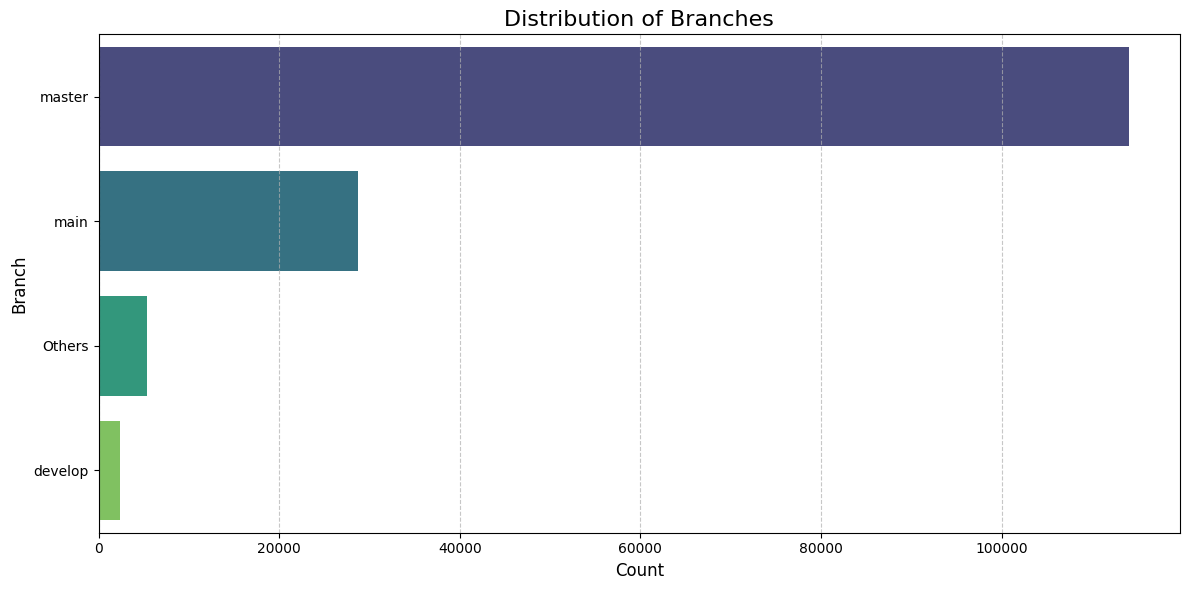

In [280]:
# Plot the distribution
plt.figure(figsize=(12, 6))
sns.countplot(
    data=data,
    y="Branch",
    order=data["Branch"].value_counts().index,
    palette="viridis"
)

# Add titles and labels
plt.title("Distribution of Branches", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Branch", fontsize=12)

# Add grid for readability
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [281]:
# Function to extract the username from the URL
def extract_username(url):
    # Split the URL by '/' and take the segment after "https://github.com/"
    return url.split("/")[3] if isinstance(url, str) and "github.com" in url else None

In [282]:
# Apply the function to the column
data["Username"] = data["URL"].apply(extract_username)

# Verify the new column
data['Username'].value_counts()

Username
microsoft           710
google              473
apache              250
facebookresearch    222
sindresorhus        201
                   ... 
acredjb               1
Lin-Yijie             1
bbrodriges            1
havard                1
nanu-c                1
Name: count, Length: 92429, dtype: int64

In [283]:
# Step 1: Identify the top 10 Username
top_10_usernames = data["Username"].value_counts().nlargest(10).index

# Step 2: Create the new variable 'TOPUsername'
data["TopUsername"] = data["Username"].apply(lambda x: x if x in top_10_usernames else "Others")

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/3743890034.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


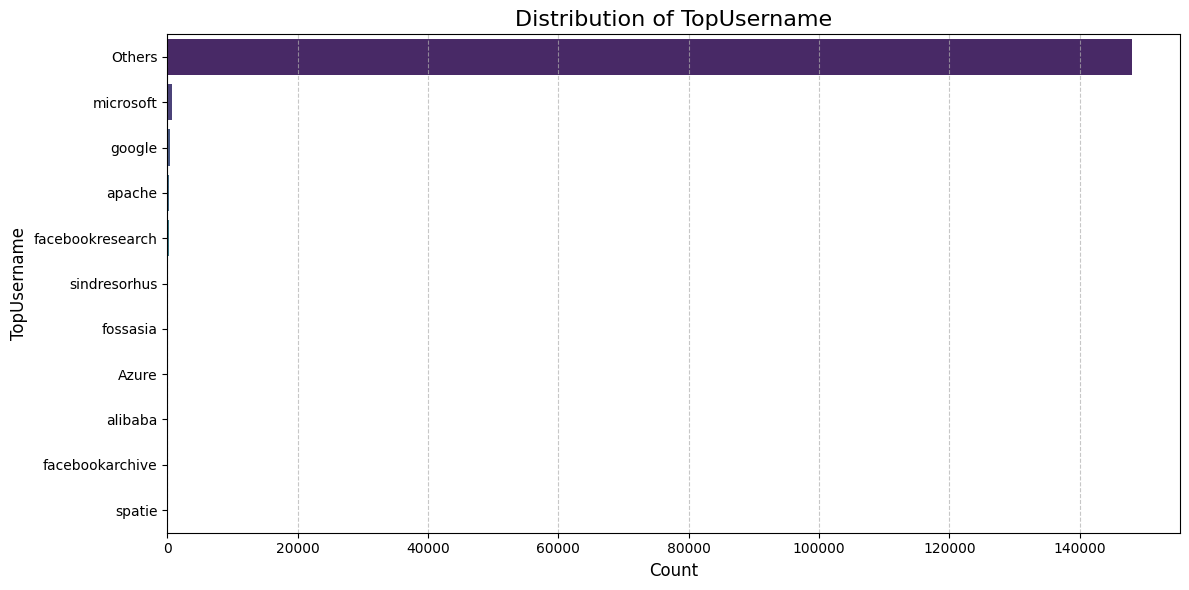

In [284]:
# Plot the distribution
plt.figure(figsize=(12, 6))
sns.countplot(
    data=data,
    y="TopUsername",
    order=data["TopUsername"].value_counts().index,
    palette="viridis"
)

# Add titles and labels
plt.title("Distribution of TopUsername", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("TopUsername", fontsize=12)

# Add grid for readability
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

#### Text Variables


In [285]:
data['Is Deprecated'] = data['Description'].str.contains('DEPRECATED', case=False, na=False)
data.groupby('Is Deprecated').describe()['Stars']

count      mean       min       25%       50%       75%  \
Is Deprecated                                                               
False          149634.0  6.220857  5.123964  5.472271  5.937536  6.685861   
True              886.0  6.270066  5.123964  5.522459  6.005120  6.759253   

                     max       std  
Is Deprecated                       
False          12.606170  0.987968  
True           10.206662  0.965195

** NOte more text eda

#### Correlations
- **Highly Correlated Variables**:
  - `Forks` and `Stars`.
  - `Has Projects` and `Has Wiki`.

Remove one variable from highly correlated pair to avoid redundancy and simplify the dataset.

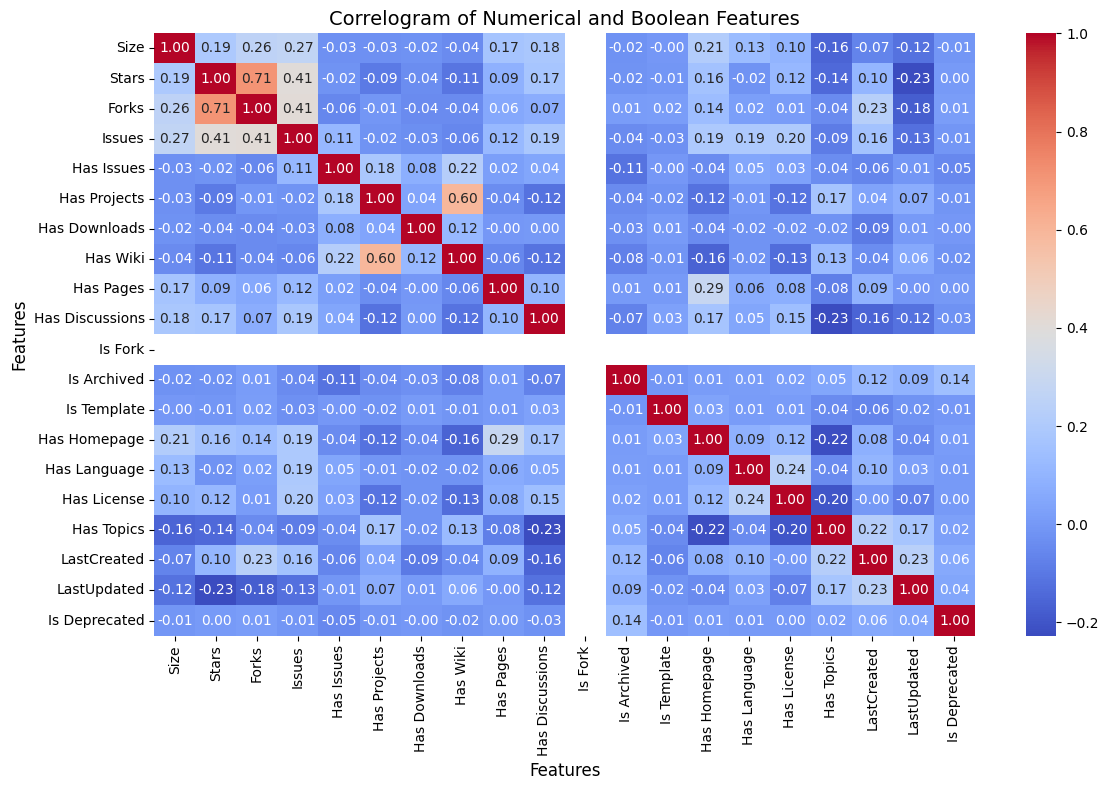

In [286]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

boolean_columns = data.select_dtypes(include=["bool"]).columns
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = data.select_dtypes(include=["float64", "int64"]).columns
numerical_data = data[numerical_columns]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add titles and labels
plt.title("Correlogram of Numerical and Boolean Features", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()

`Has Wiki` and `Has Projects` shows a moderate positive relationship. Repositories that have a project are also likely to have a wiki. This could suggest redundancy, but it doesn’t necessarily mean one feature is irrelevant.

We need to check Feature Importans to evaluate the contribution to the target variable. 


#### Relationships

Relationship between `Topics` and `Languages`

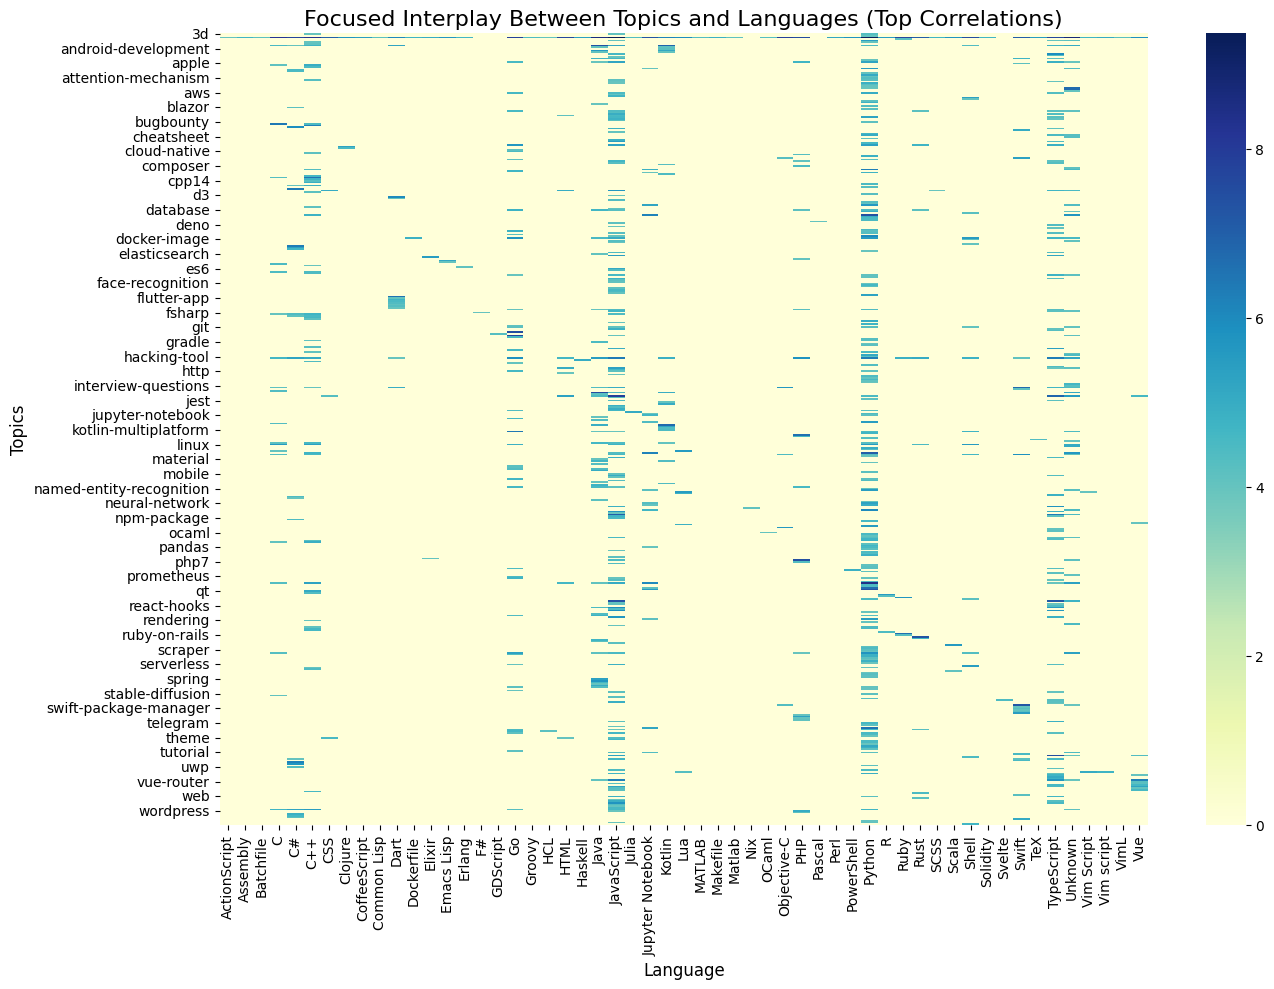

In [287]:
# Explode Topics column into multiple rows
data_exploded = data.copy()
data_exploded["Topics"] = data_exploded["Topics"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
data_exploded = data_exploded.explode("Topics")

# Clean the Topics column to remove unwanted characters like [] and '
data_exploded["Topics"] = data_exploded["Topics"].str.replace(r"[\[\]']", "", regex=True).str.strip()

# Group by Language and Topics, then count occurrences
grouped_data = data_exploded.groupby(["Language", "Topics"]).size().reset_index(name="Count")

# Filter for top correlations (counts > threshold)
threshold = 50  # Adjust based on the data distribution
filtered_data = grouped_data[grouped_data["Count"] > threshold]

# Pivot the filtered data for heatmap
filtered_heatmap_data = filtered_data.pivot(index="Topics", columns="Language", values="Count").fillna(0)

# Optional: Apply log transformation for scaling
filtered_heatmap_data_log = np.log1p(filtered_heatmap_data)

# Create a heatmap with filtered data
plt.figure(figsize=(14, 10))
sns.heatmap(
    filtered_heatmap_data_log,  # Use filtered log-transformed data
    cmap="YlGnBu",
    annot=False,
    cbar=True,
    vmax=filtered_heatmap_data_log.values.max()  # Set explicit max range for color bar
)

# Add titles and labels
plt.title("Focused Interplay Between Topics and Languages (Top Correlations)", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Topics", fontsize=12)

plt.tight_layout()
plt.show()

**Note:

To analyze the relationships as requested, I would explore the interplay between ‘Topics’ and ‘Language’ using a heatmap to visualize the frequency of specific topics associated with each programming language. For the relationship between ‘Repository Age’ and ‘Stars,’ I would create scatterplots to observe trends and patterns, potentially complemented by regression lines to highlight correlations.

#### Outliers Analysis 

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


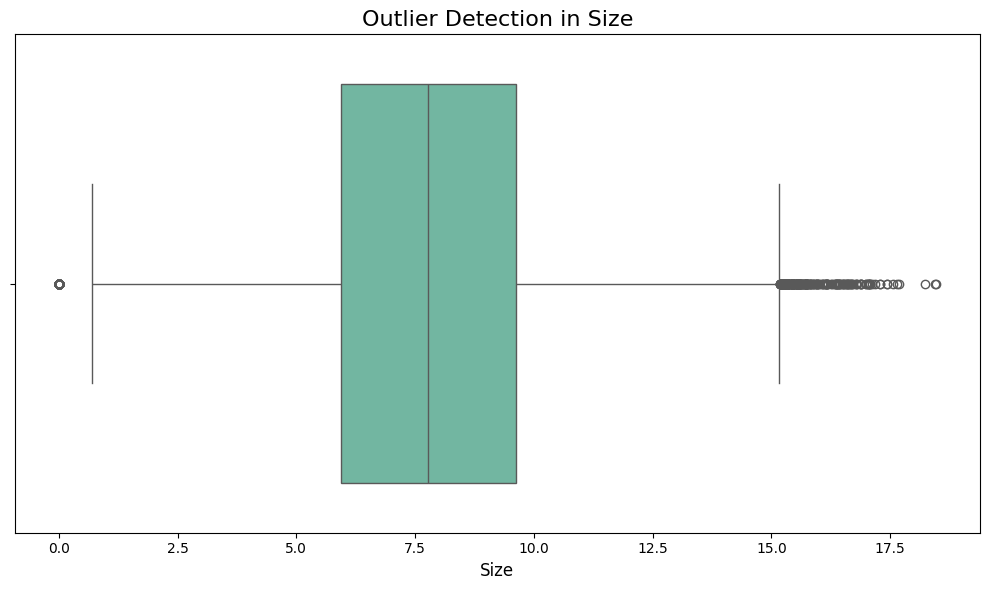

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


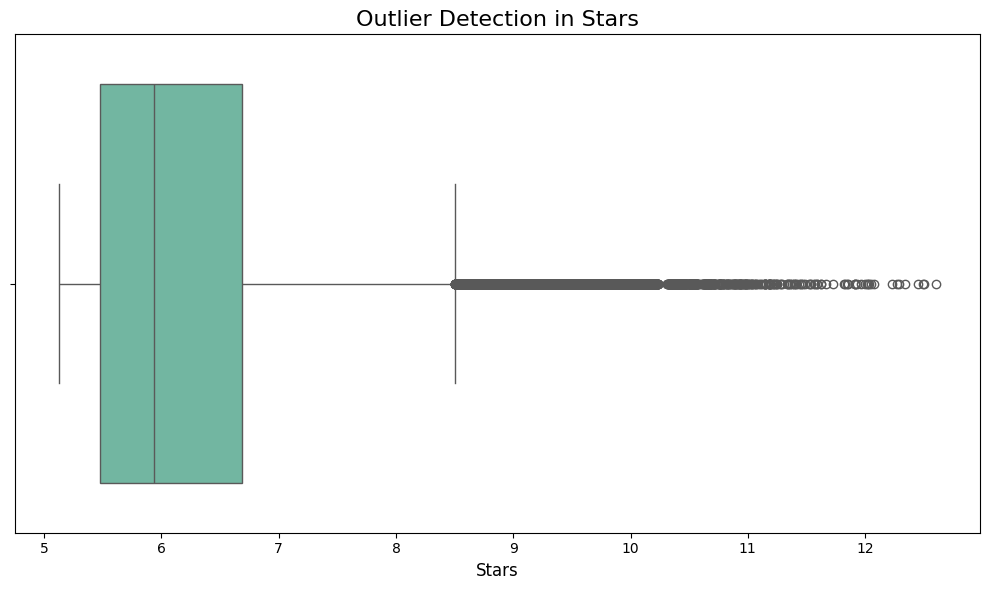

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


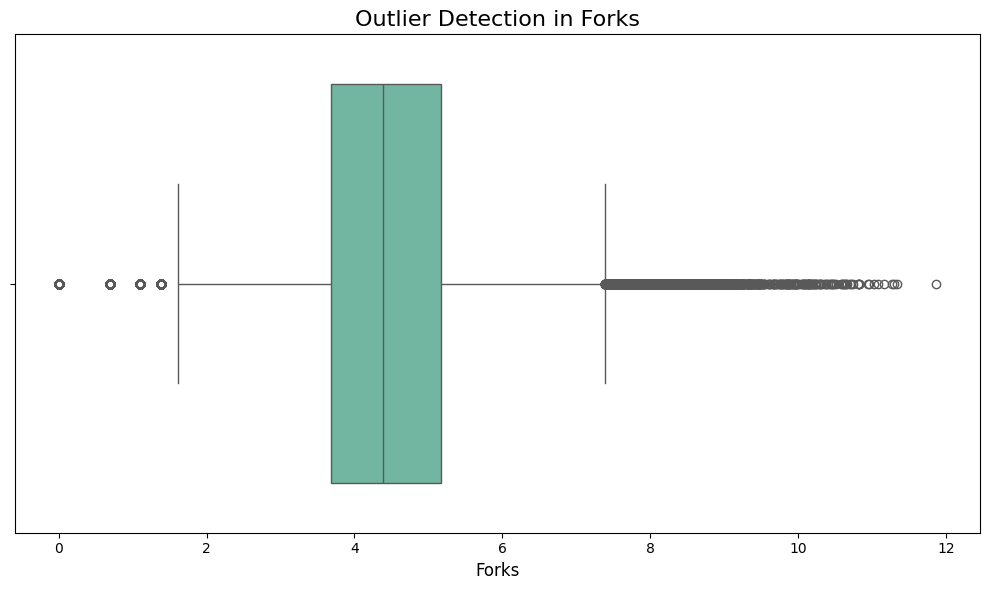

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


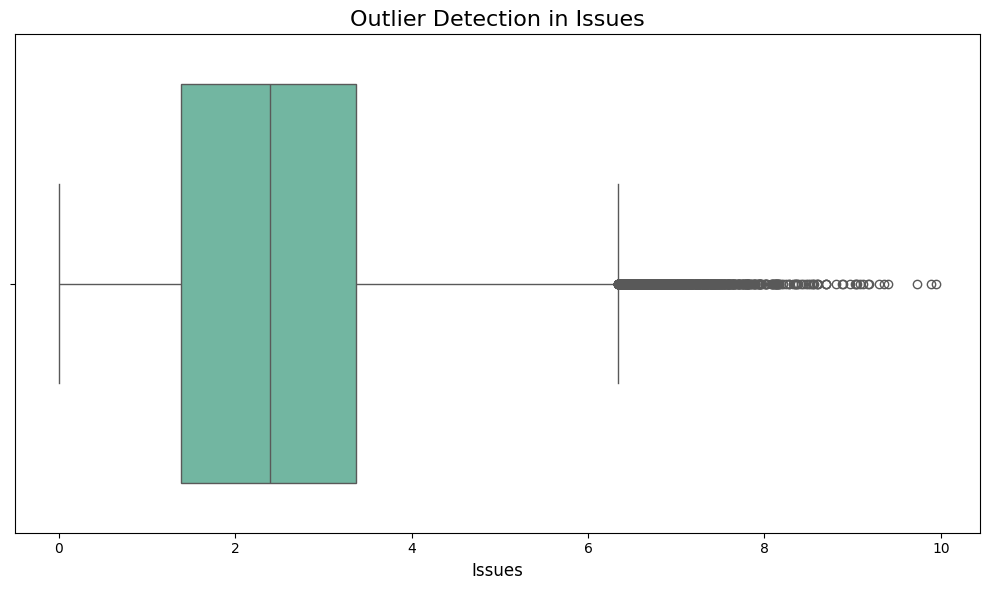

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


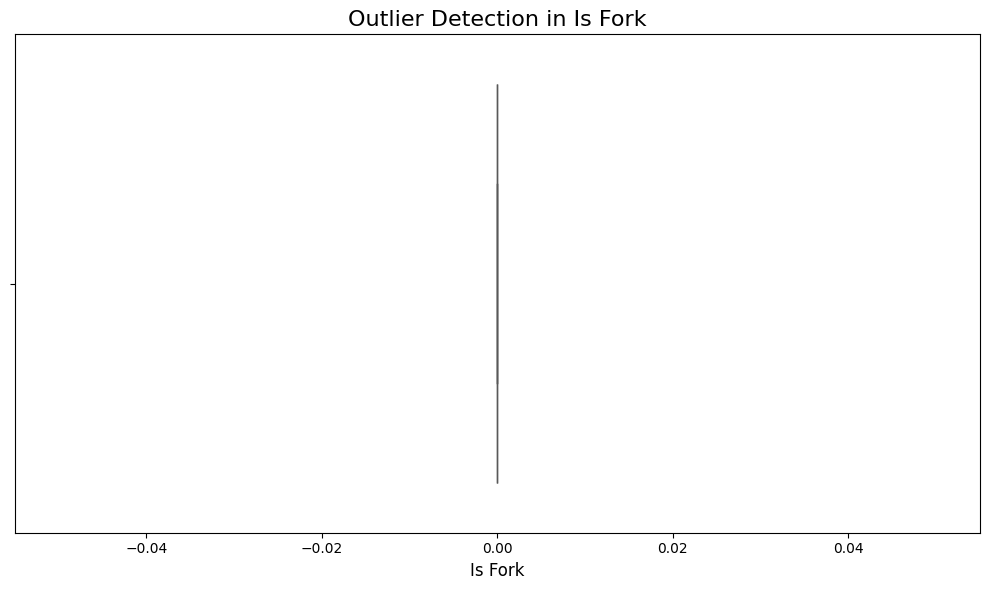

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


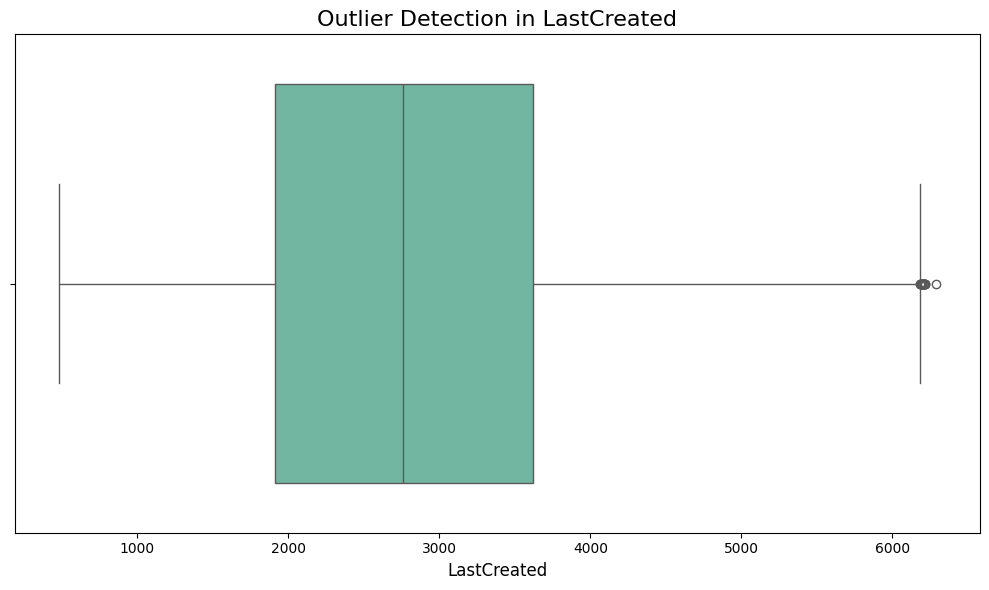

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_17695/1837475729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[column], palette="Set2")


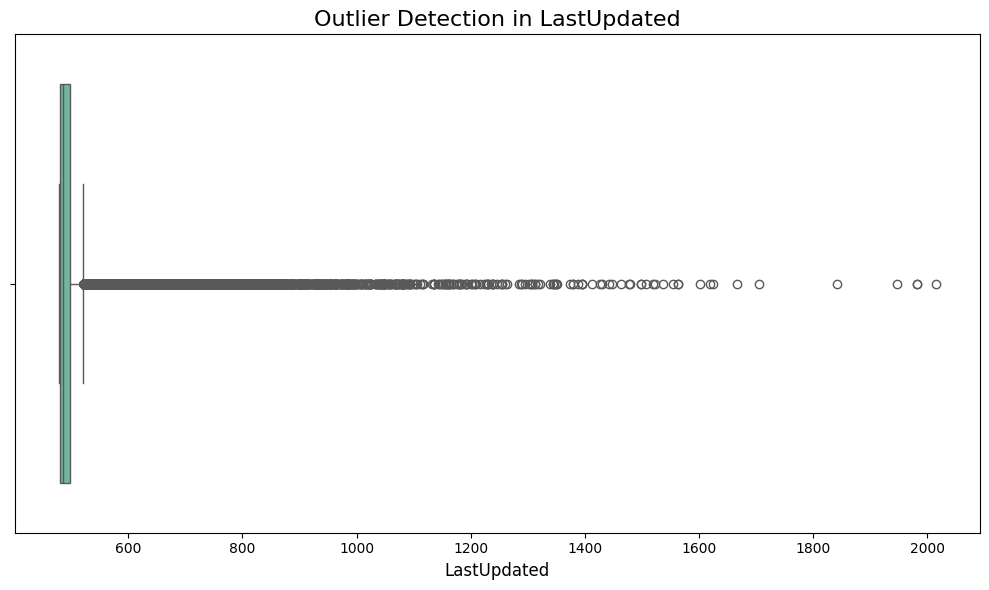

In [288]:
boolean_like_columns = [col for col in data.columns if data[col].nunique() == 2]

numerical_columns = data.select_dtypes(include=["float64", "int64"]).columns
filtered_columns = [col for col in numerical_columns if col not in boolean_like_columns]

for column in filtered_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column], color="darkblue")
    plt.title(f"Outlier Detection in {column}", fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.tight_layout()
    plt.show()

** Note:

I did not have sufficient time to perform a detailed analysis of outliers in the dataset. However, if time allowed, I would investigate the most extreme outliers for each numerical feature to understand their potential impact.

#### Create Preprocessed DF

In [289]:
def preprocess(df):
    ''' Preprocess and Prepare the data for modelling'''

    # Handle Skewed Distributions
    skewed_columns = ["Size", "Stars", "Forks", "Issues"]
    df = log_transform(df, skewed_columns)

    # Handle Missing Values
    df['Has Homepage'] = df['Homepage'].notna()
    df['Has Language'] = df['Language'].notna()
    df['Has Language'] = df['Language'].notna()
    df['Has Topics'] = (df['Topics'].str.strip() == "[]")

    # Replace empty values with "Unknown"
    df['Language'] = df['Language'].fillna("Unknown")
    df['License'] = df['License'].fillna("Unknown")
    df['Topics'] = df['Topics'].replace("[]", "['Unknown']")

    # Time Variables
    df["Created At"] = pd.to_datetime(df["Created At"]).dt.tz_localize(None)
    df["Updated At"] = pd.to_datetime(df["Updated At"]).dt.tz_localize(None)
    today = pd.Timestamp.today().replace(tzinfo=None)
    df["LastCreated"] = (today - df["Created At"]).dt.days
    df["LastUpdated"] = (today - df["Updated At"]).dt.days

    # Categorical Variables
    top_3_branches = df["Default Branch"].value_counts().nlargest(3).index
    df["Branch"] = df["Default Branch"].apply(lambda x: x if x in top_3_branches else "Others")

    # Text Variables
    df['Is Deprecated'] = df['Description'].str.contains('DEPRECATED', case=False, na=False)
    df["Username"] = df["URL"].apply(extract_username)
    top_10_usernames = df["Username"].value_counts().nlargest(10).index
    df["TopUsername"] = df["Username"].apply(lambda x: x if x in top_10_usernames else "Others")
    
    # Drop columns
    df.drop(['Name','Is Fork', 'URL', 'Homepage', 'Created At', 'Updated At', 'Default Branch', 'Username', 'Description', 'Topics'], axis=1, inplace=True) # All Constant Values 

    return df


In [290]:
preprocessed_df = preprocess(df)

In [291]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150520 entries, 0 to 150519
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Size             150520 non-null  float64
 1   Stars            150520 non-null  float64
 2   Forks            150518 non-null  float64
 3   Issues           150520 non-null  float64
 4   Language         150520 non-null  object 
 5   License          150520 non-null  object 
 6   Has Issues       150520 non-null  bool   
 7   Has Projects     150520 non-null  bool   
 8   Has Downloads    150520 non-null  bool   
 9   Has Wiki         150520 non-null  bool   
 10  Has Pages        150520 non-null  bool   
 11  Has Discussions  150520 non-null  bool   
 12  Is Archived      150520 non-null  bool   
 13  Is Template      150520 non-null  bool   
 14  Has Homepage     150520 non-null  bool   
 15  Has Language     150520 non-null  bool   
 16  Has Topics       150520 non-null  bool

### Feature Engineering & Modeling (Pipelines)

In [295]:
# Define the target and features
target = "Stars"
X = preprocessed_df.drop(columns=[target])
y = preprocessed_df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [296]:
# Identify columns
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns
boolean_features = X.select_dtypes(include=["bool"]).columns

In [297]:
# 1. Preprocessing Pipeline
# Numeric pipeline: Handle skewness and scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing values
    ("scaler", StandardScaler())  # Scale the features
])

# Categorical pipeline: Impute missing and one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Boolean pipeline: Convert booleans to integers
boolean_transformer = Pipeline(steps=[
    ("convert_to_int", FunctionTransformer(lambda x: x.astype(int))),  # Convert bool to int
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),  # Handle missing values
])

# Combine all transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bool", boolean_transformer, boolean_features),
    ]
)

In [302]:
# 2. Define Models
# Define the pipelines
pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))  # Random Forest Model
])

pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(objective="reg:squarederror", random_state=42))  # XGBoost Model
])

In [303]:
# Show Pipeline
pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Size', 'Forks', 'Issues', 'LastCreated', 'LastUpdated'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEnco...
                                                                   FunctionTransformer(func=<function <lambda> at 0x3bfa202c0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  Index(['Has Issues', 'Has Projects', 'Has Downloads', 'Has Wiki', 'Has Pages',
       'Has Discussions', 'Is Archived', 'Is Template', 'Has Homepage',
       'Has Language', 'Has Topics', 'Is Deprecated'],
      dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

### Train & Evaluate 

In [304]:
# Train and evaluate Random Forest
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Results:")
print(f"R2 Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Random Forest Results:
R2 Score: 0.7005
RMSE: 0.5403


In [305]:
# Train and evaluate XGBoost
pipeline_xgb.fit(X_train, y_train)
y_pred_lr = pipeline_xgb.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("\nXGBoost Results:")
print(f"R2 Score: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")

/Users/anoguera/anaconda3/envs/crypto/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Compare the results
if r2_rf > r2_lr:
    print("\nRandom Forest performs better than XGBoost.")
    pipeline = pipeline_rf
else:
    print("\nXGBoost performs better than Random Forest.")
    pipeline = pipeline_xgb

In [308]:
pipeline = pipeline_rf

**Note: 

To **save computational time**, I didn't use cross-validation (CV) or grid search for hyperparameter tuning. However, for more robust model evaluation and parameter optimization, it is recommended to:
1. Use **cross-validation** to reduce the risk of overfitting to a single train-test split.
2. Perform **grid search**, **hyperopt** or **randomized search** to identify the optimal hyperparameters for each model.

### Feature Importance

Update Frequency is important to get more stars

In [309]:
# Extract feature importance
importance = pipeline.named_steps["model"].feature_importances_

# Get feature names
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_names, importance, color="skyblue")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Random Forest Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

AttributeError: Estimator convert_to_int does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

### Generate Predictions

In [ ]:
# Import Prediction Set
prediction_set = pd.read_csv('data/github-repo-prediction-set.csv')

In [ ]:
# Preprocess Prediction Set
preprocessed_df_pred = preprocess(prediction_set)

In [ ]:
# Create Predictions for Prediction Set
predictions = pipeline.predict(X_test)

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({
    "Name": prediction_set["Name"],  # Retain the Name column for submission
    "Prediction": predictions  # Add predictions
})

# Save submission file as CSV
submission.to_csv("data/submission.csv", index=False)

print(submission.head())